# Building Data Genome Project 2.0
## Predictive models

Biam! (pic.biam@gmail.com)

In [1]:
# data and numbers
import numpy as np
import pandas as pd
import math
import datetime
from glob import glob
import gc

# Metrics & Models
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

In [2]:
path_metadata = "..\\data\\metadata\\"
path_weather = "..\\data\\weather\\"
path_meter_raw = "..\\data\\meters\\raw\\"
path_meter_cleaned = "..\\data\\meters\\cleaned\\"
path_meter_proc = "..\\data\\meters\\processed\\"

# Introduction

# Functions

Source code for this function: https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction

In [3]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
# This function concatenate all prediction in one dataframe
# input: files directory list
# output: single dataframe with all predictions

def ConcatAllModels(files):
    dfs = [] # empty list of the dataframes to create
    for file in files: # for each file in directory
        
        model_name = file.split("\\")[3].split("_")[1].split(".")[0] # model_name to rename the model feature
        
        if model_name == "real": # don't rename column
            
            model = pd.read_csv(file) # load the dataset
            
        else: # rename column
            
            model = pd.read_csv(file, header=0, names=[model_name])
            
            
        dfs.append(model) # append to list
    complete_data = pd.concat(dfs, axis=1, ignore_index=False, sort=False) # concatenate all models
   
    return complete_data

# Datasets

## Feature selection

In this notebook only a selection of features will be used.<br>

<i>Building metadata</i>
<ul>
    <li>Building ID*</li>
    <li>Site ID*</li>
    <li>Primary space usage</li>
    <li>Building size (sqm)</li>
</ul>
<i>Weather data</i>
<ul>
    <li>Timestamp*</li>
    <li>Site ID*</li>
    <li>Air temperature</a></li>
</ul>
<i>Meter reading data</i>
<ul>
    <li>Timestamp*</li>
    <li>Building ID*</li>
    <li>meter</li>
    <li>meter reading (target)</li>
</ul>

## Metadata

**Buildings metadata**
* `building_id`: building code-name with the structure <i>SiteID_[SimplifiedUsage](https://github.com/buds-lab/building-data-genome-project-2/wiki/Simplified-PSU)_UniqueName</i>.
* `site_id`: animal-code-name for the site.
* `building_id_kaggle`: building ID used for the [Kaggle competition](https://www.kaggle.com/c/ashrae-energy-prediction) (numeric).
* `site_id_kaggle`: site ID used for the [Kaggle competition](https://www.kaggle.com/c/ashrae-energy-prediction) (numeric).
* `primaryspaceusage`: Primary space usage of all buildings is mapped using the [energystar scheme building description types](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/identify-your-property-type). 
* `sub_primaryspaceusage`: [energystar scheme building description types](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/identify-your-property-type) subcategory.
* `sqm`: Floor area of building in square meters (m2). 
* `lat`: Latitude of building location to city level.
* `lng`: Longitude of building location to city level.
* `timezone`: site's timezone.
* `electricity`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `hotwater`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `chilledwater`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `steam`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `water`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `irrigation`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `solar`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `gas`: presence of this kind of meter in the building. `Yes` if affirmative, `NaN` if negative.
* `industry`: Industry type corresponding to building.
* `subindustry`: More detailed breakdown of Industry type corresponding to building.
* `heatingtype`: Type of heating in corresponding building.
* `yearbuilt`: Year corresponding to when building was first constructed, in the format YYYY.
* `date_opened`: Date building was opened for use, in the format D/M/YYYY.
* `numberoffloors`: Number of floors corresponding to building.
* `occupants`: Usual number of occupants in the building.
* `energystarscore`: Rating of building corresponding to building energystar scheme ([Energy Star Score](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/understand-metrics/how-1-100)).
* `eui`: [Energy use intensity](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/understand-metrics/what-energy) of the building (kWh/year/m2).
* `site_eui`: Energy (Consumed/Purchased) use intensity of the site (kWh/year/m2).
* `source_eui`: Total primary energy consumption normalized by area (Takes into account conversion efficiency of primary energy into secondary energy).
* `leed_level`: LEED rating of the building ([Leadership in Energy and Environmental Design](https://en.wikipedia.org/wiki/Leadership_in_Energy_and_Environmental_Design")), most widely used green building rating system.
* `rating`: Other building energy ratings.

In [6]:
# Buildings metadata
metadata = pd.read_csv(path_metadata + "metadata.csv", usecols = ["building_id",
                                                                 "site_id",
                                                                 "primaryspaceusage",
                                                                 "sqm",
                                                                 ])

metadata = reduce_mem_usage(metadata)
metadata.info()

Mem. usage decreased to  0.04 Mb (12.5% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   building_id        1636 non-null   object 
 1   site_id            1636 non-null   object 
 2   primaryspaceusage  1615 non-null   object 
 3   sqm                1636 non-null   float32
dtypes: float32(1), object(3)
memory usage: 44.9+ KB


In [7]:
# missing values
metadata.isna().sum()*100/len(metadata)

building_id          0.000000
site_id              0.000000
primaryspaceusage    1.283619
sqm                  0.000000
dtype: float64

In [8]:
metadata[metadata.primaryspaceusage.isna() == True]

,building_id,site_id,primaryspaceusage,sqm
1179,Swan_unknown_Reyna,Swan,NaN,6154.500000
1180,Swan_unknown_Douglas,Swan,NaN,7736.200195
1181,Swan_unknown_Darrin,Swan,NaN,6319.799805
1182,Swan_unknown_Ike,Swan,NaN,6928.100098
1183,Swan_unknown_Esteban,Swan,NaN,6976.399902
1184,Swan_unknown_Christoper,Swan,NaN,8636.599609
1185,Swan_unknown_Isaiah,Swan,NaN,14806.299805
1186,Swan_unknown_Tom,Swan,NaN,4645.000000
1187,Swan_unknown_Jan,Swan,NaN,14952.000000
1188,Swan_unknown_Andres,Swan,NaN,11538.700195


In [9]:
metadata.primaryspaceusage.fillna("Unknown", inplace=True)

In [10]:
# missing values
metadata.isna().sum()*100/len(metadata)

building_id          0.0
site_id              0.0
primaryspaceusage    0.0
sqm                  0.0
dtype: float64

## Weather

**Weather** 
* `timestamp`: date and time in the format YYYY-MM-DD hh:mm:ss. Local timezone. 
* `site_id`: animal-code-name for the site. * `airTemperature`: The temperature of the air in degrees Celsius (ºC). 
* `cloudCoverage`: Portion of the sky covered in clouds, in [oktas](https://en.wikipedia.org/wiki/Okta). 
* `dewTemperature`: The dew point (the temperature to which a given parcel of air must be cooled at constant pressure and water vapor content in order for saturation to occur) in degrees Celsius (ºC). 
* `precipDepth1HR`: The depth of liquid precipitation that is measured over a one hour accumulation period (mm). 
* `precipDepth6HR`: The depth of liquid precipitation that is measured over a six hour accumulation period (mm). 
* `seaLvlPressure`: The air pressure relative to Mean Sea Level (MSL) (mbar or hPa). 
* `windDirection`: The angle, measured in a clockwise direction, between true north and the direction from which the wind is blowing (degrees). 
* `windSpeed`: The rate of horizontal travel of air past a fixed point (m/s).

In [11]:
# Weather data
weather = pd.read_csv(path_weather + "weather.csv", usecols = ["timestamp",
                                                                  "site_id",
                                                                  "airTemperature"
                                                                  ])
weather = reduce_mem_usage(weather)
weather.info()

Mem. usage decreased to  5.68 Mb (25.0% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331166 entries, 0 to 331165
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       331166 non-null  object 
 1   site_id         331166 non-null  object 
 2   airTemperature  331038 non-null  float16
dtypes: float16(1), object(2)
memory usage: 5.7+ MB


In [12]:
weather.isna().sum()*100/len(weather)

timestamp         0.000000
site_id           0.000000
airTemperature    0.038651
dtype: float64

In [14]:
# Fill NaN with interpolation
weather.airTemperature.interpolate(method="linear",inplace=True)

In [15]:
weather.isna().sum()*100/len(weather)

timestamp         0.0
site_id           0.0
airTemperature    0.0
dtype: float64

## Meters

### Join all cleaned datasets

In [16]:
# files in directory
files = glob(path_meter_cleaned + "*.csv")

In [17]:
files

['..\\data\\meters\\cleaned\\chilledwater_cleaned.csv',
 '..\\data\\meters\\cleaned\\electricity_cleaned.csv',
 '..\\data\\meters\\cleaned\\gas_cleaned.csv',
 '..\\data\\meters\\cleaned\\hotwater_cleaned.csv',
 '..\\data\\meters\\cleaned\\irrigation_cleaned.csv',
 '..\\data\\meters\\cleaned\\solar_cleaned.csv',
 '..\\data\\meters\\cleaned\\steam_cleaned.csv',
 '..\\data\\meters\\cleaned\\water_cleaned.csv']

In [18]:
dfs = [] # empty list of the dataframes to create
for file in files: # for each file in directory
    meter_type = file.split("\\")[4].split(".")[0].split("_")[0]# meter_type to rename the value feature
    meter = pd.read_csv(file) # load the dataset
    meter = pd.melt(meter, id_vars = "timestamp", var_name = "building_id", value_name = "meter_reading") # melt dataset
    meter["meter"] = str(meter_type) # adds column with the meter type
    dfs.append(meter) # append to list
complete_data = pd.concat(dfs, axis=0, ignore_index=True) # concatenate all meter
del(dfs, meter, file, files, meter_type)

In [19]:
complete_data.head()

,timestamp,building_id,meter_reading,meter
0,2016-01-01 00:00:00,Panther_office_Clementine,NaN,chilledwater
1,2016-01-01 01:00:00,Panther_office_Clementine,NaN,chilledwater
2,2016-01-01 02:00:00,Panther_office_Clementine,NaN,chilledwater
3,2016-01-01 03:00:00,Panther_office_Clementine,NaN,chilledwater
4,2016-01-01 04:00:00,Panther_office_Clementine,NaN,chilledwater


In [20]:
# Check the meters
complete_data["meter"].value_counts()

electricity     27684432
chilledwater     9736920
steam            6491280
hotwater         3245640
gas              3105288
water            2561424
irrigation        649128
solar              87720
Name: meter, dtype: int64

In [10]:
# Check number of buildings
len(np.unique(complete_data["building_id"]))

1636

In [21]:
# Export dataset
complete_data.to_csv(path_meter_proc + "allmeters_cleaned.csv", index=False)

**All meters dataset (meter reading)**
*   `timestamp`: date and time in the format YYYY-MM-DD hh:mm:ss. 2016 and 2017 data.
*   `building_id`: building code-name with the structure _UniqueFirstName_SiteID_primaryspaceusage_.
*   `meter_reading`: meter reading in kilowatt hour (kWh) .
*   `meter`: meter type, `chilledwater`, `electricity`, `gas`, `hotwater`, `irrigation`, `steam` or `water`.

In [26]:
# Meters data
data = pd.read_csv(path_meter_proc + "allmeters_cleaned.csv")
data = reduce_mem_usage(data)
data.info()

Mem. usage decreased to 1430.26 Mb (12.5% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53561832 entries, 0 to 53561831
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      object 
 1   building_id    object 
 2   meter_reading  float32
 3   meter          object 
dtypes: float32(1), object(3)
memory usage: 1.4+ GB


In [27]:
# missing data
data.isna().sum()*100/len(data)

timestamp         0.000000
building_id       0.000000
meter_reading    15.695718
meter             0.000000
dtype: float64

In [28]:
# number of buildings in dataset
len(data.building_id.unique())

1636

In [29]:
# Drop missings
data.dropna(inplace=True)

In [30]:
# missing data
data.isna().sum()*100/len(data)

timestamp        0.0
building_id      0.0
meter_reading    0.0
meter            0.0
dtype: float64

In [31]:
# number of buildings in dataset after dropping Nan
len(data.building_id.unique())

1631

# Feature engineering based on EDA

Based on [EDA of meter readings](https://github.com/buds-lab/building-data-genome-project-2/blob/master/notebooks/03_EDA-meter-reading.ipynb):

*   _Healthcare_, _Food sales and services_ and _Utility_ usages shows the highest meter reading values.
*   _Hotwater_ meter shows the highest meter reading values.
*   Monthly behaviour (meter-reading median) shows higher readings in warm season.
*   Hourly behaviour (meter-reading median) shows gihger values from 6 to 19 hs.
*   Weekday behaviour: lowers during weekends.

Based on this observations _month_, _day of the week_ and _hour of the day_ will be added. `primaryspaceusage` categories (16) will be reduced to _healthcare, food, utility_ and _other_. `meter` categories (8) will be preserved. Final features will be:

*   Timestamp*
*   Site ID
*   Building ID
*   Month
*   Hour
*   Day of the week
*   Usage (dummy, 4 levels: _healthcare, food, utility, other_)
*   Building size (sqft)
*   Air temperature
*   Meter (dummy, 8 levels)
*   Meter reading / target

In [33]:
# Reduce primary space usage categories to 3: Healthcare, Utilty, other
metadata.loc[(metadata["primaryspaceusage"] != "Healthcare") & (metadata["primaryspaceusage"] != "Utility") & (metadata["primaryspaceusage"] != "Food sales and service"), "primaryspaceusage"] = "other"

In [34]:
# Check new categories
metadata.primaryspaceusage.unique()

array(['other', 'Food sales and service', 'Healthcare', 'Utility'],
      dtype=object)

In [35]:
# Converts to timestamp
data["timestamp"] = pd.to_datetime(data["timestamp"], format='%Y-%m-%d %H:%M:%S')
weather["timestamp"] = pd.to_datetime(weather["timestamp"], format='%Y-%m-%d %H:%M:%S')

In [36]:
# Add features
data["month"] = data.timestamp.dt.month
data["weekday"] = data.timestamp.dt.weekday
data["hour"] = data.timestamp.dt.hour

In [37]:
# Merge datasets
data = pd.merge(data, metadata, how="left", on="building_id").merge(weather, how="left", on = ["timestamp", "site_id"])

In [38]:
data.head()

,timestamp,building_id,meter_reading,meter,month,weekday,hour,site_id,primaryspaceusage,sqm,airTemperature
0,2016-02-29 09:00:00,Panther_office_Clementine,136.076904,chilledwater,2,0,9,Panther,other,3100.199951,16.703125
1,2016-02-29 10:00:00,Panther_office_Clementine,222.671402,chilledwater,2,0,10,Panther,other,3100.199951,21.093750
2,2016-02-29 11:00:00,Panther_office_Clementine,235.042007,chilledwater,2,0,11,Panther,other,3100.199951,21.703125
3,2016-02-29 12:00:00,Panther_office_Clementine,247.412598,chilledwater,2,0,12,Panther,other,3100.199951,22.203125
4,2016-02-29 13:00:00,Panther_office_Clementine,272.153900,chilledwater,2,0,13,Panther,other,3100.199951,23.906250


In [39]:
del(weather, metadata)

In [40]:
# Missing values
data.isna().sum()*100/len(data)

timestamp            0.000000
building_id          0.000000
meter_reading        0.000000
meter                0.000000
month                0.000000
weekday              0.000000
hour                 0.000000
site_id              0.000000
primaryspaceusage    0.000000
sqm                  0.000000
airTemperature       0.407504
dtype: float64

In [41]:
data.airTemperature.interpolate(method="linear", inplace=True)

In [42]:
data.isna().sum()*100/len(data)

timestamp            0.0
building_id          0.0
meter_reading        0.0
meter                0.0
month                0.0
weekday              0.0
hour                 0.0
site_id              0.0
primaryspaceusage    0.0
sqm                  0.0
airTemperature       0.0
dtype: float64

In [43]:
# Rounds to 4 decimals
data["meter_reading"] = data['meter_reading'].astype(float).round(4)
data["airTemperature"] = data['airTemperature'].astype(float).round(2)

In [44]:
data.head()

,timestamp,building_id,meter_reading,meter,month,weekday,hour,site_id,primaryspaceusage,sqm,airTemperature
0,2016-02-29 09:00:00,Panther_office_Clementine,136.0769,chilledwater,2,0,9,Panther,other,3100.199951,16.70
1,2016-02-29 10:00:00,Panther_office_Clementine,222.6714,chilledwater,2,0,10,Panther,other,3100.199951,21.09
2,2016-02-29 11:00:00,Panther_office_Clementine,235.0420,chilledwater,2,0,11,Panther,other,3100.199951,21.70
3,2016-02-29 12:00:00,Panther_office_Clementine,247.4126,chilledwater,2,0,12,Panther,other,3100.199951,22.20
4,2016-02-29 13:00:00,Panther_office_Clementine,272.1539,chilledwater,2,0,13,Panther,other,3100.199951,23.91


In [45]:
data.to_csv(path_meter_proc + "dev_merged.csv", index=False)

# Predictive models

## Long-term prediction: whole year 2017 prediction

**Train:** whole year 2016 (01/2016 to 12/2016)<br>
**Validation:** whole year 2017 (01/2017 to 12/2017)

<img src="..\\figures\\split_longterm.png">

In [5]:
# Load dataset
data = pd.read_csv(path_meter_proc + "dev_merged.csv")
# Reduce memory
data = reduce_mem_usage(data)

Mem. usage decreased to 2282.59 Mb (39.8% reduction)


In [6]:
# Rounds to 4 decimals
data["meter_reading"] = data['meter_reading'].astype(float).round(4)
data["airTemperature"] = data['airTemperature'].astype(float).round(2)
data["sqm"] = data['sqm'].astype(float).round(2)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45159855 entries, 0 to 45159854
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   timestamp          object 
 1   building_id        object 
 2   meter_reading      float64
 3   meter              object 
 4   month              int8   
 5   weekday            int8   
 6   hour               int8   
 7   site_id            object 
 8   primaryspaceusage  object 
 9   sqm                float64
 10  airTemperature     float64
dtypes: float64(3), int8(3), object(5)
memory usage: 2.8+ GB


In [8]:
data.head()

,timestamp,building_id,meter_reading,meter,month,weekday,hour,site_id,primaryspaceusage,sqm,airTemperature
0,2016-02-29 09:00:00,Panther_office_Clementine,136.0769,chilledwater,2,0,9,Panther,other,3100.2,16.70
1,2016-02-29 10:00:00,Panther_office_Clementine,222.6714,chilledwater,2,0,10,Panther,other,3100.2,21.09
2,2016-02-29 11:00:00,Panther_office_Clementine,235.0420,chilledwater,2,0,11,Panther,other,3100.2,21.70
3,2016-02-29 12:00:00,Panther_office_Clementine,247.4126,chilledwater,2,0,12,Panther,other,3100.2,22.20
4,2016-02-29 13:00:00,Panther_office_Clementine,272.1539,chilledwater,2,0,13,Panther,other,3100.2,23.91


In [9]:
# Converts to timestamp
data["timestamp"] = pd.to_datetime(data["timestamp"], format='%Y-%m-%d %H:%M:%S')

In [10]:
# Strategy split
train = data[data["timestamp"] < "2017-01-01 00:00:00"]
val = data[data["timestamp"] >= "2017-01-01 00:00:00"]
del(data)

Let's check we have the same buildings in both datasets:

In [11]:
# List of unique buildings in each dataset
train_bdg = pd.DataFrame(train.building_id.unique()).rename(columns={0:"train"})
val_bdg = pd.DataFrame(val.building_id.unique()).rename(columns={0:"val"})
# Number of unique buildings in each dataset
print("Buildings in train: " + str(len(train_bdg)))
print("Buildings in val: " + str(len(val_bdg)))
# list of shared buildings in both datasets
shared_bdg = list(pd.merge(train_bdg, val_bdg, how="inner", left_on="train",right_on="val").drop("val",axis=1).rename(columns={"train":"unique_bdg"}).unique_bdg)
print("Buildings in val AND train: " + str(len(shared_bdg)))
del(train_bdg, val_bdg)

Buildings in train: 1596
Buildings in val: 1608
Buildings in val AND train: 1573


Let's select the shared buildings for the model:

In [12]:
train = train[train.building_id.isin(shared_bdg) == True]
val = val[val.building_id.isin(shared_bdg) == True]

In [13]:
# List of unique buildings in each dataset
train_bdg = pd.DataFrame(train.building_id.unique()).rename(columns={0:"train"})
val_bdg = pd.DataFrame(val.building_id.unique()).rename(columns={0:"val"})
# Number of unique buildings in each dataset
print("Buildings in train: " + str(len(train_bdg)))
print("Buildings in val: " + str(len(val_bdg)))
# list of shared buildings in both datasets
shared_bdg = list(pd.merge(train_bdg, val_bdg, how="inner", left_on="train",right_on="val").drop("val",axis=1).rename(columns={"train":"unique_bdg"}).unique_bdg)
print("Buildings in val AND train: " + str(len(shared_bdg)))
del(train_bdg, val_bdg, shared_bdg)

Buildings in train: 1573
Buildings in val: 1573
Buildings in val AND train: 1573


### Real values

In [17]:
val_real = val[["timestamp","building_id","meter","meter_reading"]]
val_real.to_csv("..\\data\\predictions\\longterm_real.csv", index=False)

In [18]:
values, counts = np.unique(val_real.meter_reading, return_counts=True)

In [19]:
print(values)
print(counts)

[0.0000000e+00 1.0000000e-04 2.0000000e-04 ... 1.1338267e+07 1.1361868e+07
 1.1652669e+07]
[1172059   60043   66981 ...       1       1       1]


In [20]:
print("Unique values: " + str(len(values)))
print("Min value: " + str(min(values)))
print("Max value: " + str(max(values)))

Unique values: 3294346
Min value: 0.0
Max value: 11652669.0


In [21]:
del(val_real, values, counts)

### Encoding and Data/Target split

In [14]:
train = train.drop("timestamp",axis=1)
val = val.drop("timestamp",axis=1)

In [15]:
"""train = train.set_index(["timestamp","building_id"])
val = val.set_index(["timestamp","building_id"])"""

'train = train.set_index(["timestamp","building_id"])\nval = val.set_index(["timestamp","building_id"])'

For LightGBM use only a label encoding (this algorith can handle categorical features by itself):

In [16]:
# Label Encoder
le_meter = LabelEncoder().fit(train.meter)
train["meter"] = le_meter.transform(train.meter)
val["meter"] = le_meter.transform(val.meter)

In [17]:
# Label Encoder
le_usage = LabelEncoder().fit(train.primaryspaceusage)
train["primaryspaceusage"] = le_usage.transform(train.primaryspaceusage)
val["primaryspaceusage"] = le_usage.transform(val.primaryspaceusage)

In [18]:
# Label Encoder
le_usage = LabelEncoder().fit(train.building_id)
train["building_id"] = le_usage.transform(train.building_id)
val["building_id"] = le_usage.transform(val.building_id)

In [19]:
# Label Encoder
le_usage = LabelEncoder().fit(train.site_id)
train["site_id"] = le_usage.transform(train.site_id)
val["site_id"] = le_usage.transform(val.site_id)

In [20]:
# Split datasets
X_train = train.drop("meter_reading", axis=1)
y_train = train["meter_reading"]

X_val = val.drop("meter_reading", axis=1)
y_val = val["meter_reading"]

del(train, val)

### LightGBM prediction

Default parameters: https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [21]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(
    X_train,
    y_train,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    free_raw_data=False,
)
lgb_eval = lgb.Dataset(
    X_val,
    y_val,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    reference=lgb_train,
    free_raw_data=False,
)

In [22]:
# Parameters
params = {
    "objective": "regression",
    "metric": "rmse",
    "random_state": 55,
    "learning_rate":0.01, # default 0.1
    "max_bin":761, # Bin temperature by 0.1 ºC. default 255
    "num_leaves": 2197 # Around 0.01% of training data. default 31
}

In [23]:
# train
print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                valid_sets = lgb_eval,
                num_boost_round=100000,
                early_stopping_rounds=1000,
                verbose_eval=100)

Starting training...


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 1000 rounds
[100]	valid_0's rmse: 65947.2
[200]	valid_0's rmse: 69372.8
[300]	valid_0's rmse: 74052.1
[400]	valid_0's rmse: 76203.6
[500]	valid_0's rmse: 77146
[600]	valid_0's rmse: 77587.7
[700]	valid_0's rmse: 77821.8
[800]	valid_0's rmse: 77939
[900]	valid_0's rmse: 78055.2
[1000]	valid_0's rmse: 78142.1
[1100]	valid_0's rmse: 78207.4
Early stopping, best iteration is:
[118]	valid_0's rmse: 65460.4


In [24]:
gbm.feature_importance()

array([ 20502,   3831,  26406,   7240,  23767,     88,   9593,  46592,
       121109])

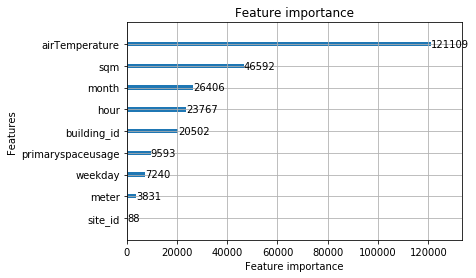

In [25]:
lgb.plot_importance(gbm)

In [26]:
# predict
print('Starting predicting...')
y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
print('Finish.')

Starting predicting...
Finish.


In [27]:
values, counts = np.unique(y_pred, return_counts=True)

In [28]:
print(values)
print(counts)

[ -20861.83535049  -16711.03494208  -15477.18063906 ... 5446747.41123732
 5457606.94802551 5461055.37838995]
[ 2 17  1 ...  2  2  2]


In [29]:
print("Unique values: " + str(len(values)))
print("Min value: " + str(min(values)))
print("Max value: " + str(max(values)))

Unique values: 297352
Min value: -20861.835350485555
Max value: 5461055.378389948


In [30]:
# Save LightGBM prediction
pd.DataFrame(y_pred).to_csv("..\\data\\predictions\\longterm_LGBM.csv", index=False, header="LGBM")

### Predictions dataset

To export a single dataset with all the predictions.

In [31]:
del(X_train, X_val, y_train, y_val)
gc.collect()

256

In [32]:
# Filepath
files = glob("..\\data\\predictions\\longterm*")

In [33]:
files

['..\\data\\predictions\\longterm_LGBM.csv',
 '..\\data\\predictions\\longterm_real.csv']

In [34]:
df_pred = ConcatAllModels(files)

In [35]:
df_pred = df_pred[["timestamp","building_id","meter","meter_reading","LGBM"]]

In [36]:
df_pred.head()

,timestamp,building_id,meter,meter_reading,LGBM
0,2017-04-17 14:00:00,Panther_office_Clementine,chilledwater,0.0000,4587.771116
1,2017-04-17 15:00:00,Panther_office_Clementine,chilledwater,86.5944,4587.771116
2,2017-04-17 16:00:00,Panther_office_Clementine,chilledwater,309.2658,4587.771116
3,2017-04-17 17:00:00,Panther_office_Clementine,chilledwater,284.5245,4587.771116
4,2017-04-17 18:00:00,Panther_office_Clementine,chilledwater,247.4126,4587.771116


In [37]:
# Saves files
df_pred.to_csv("..\\data\\predictions\\longterm_pred.csv", index=False)

## Short term prediction

**train:** 1 month (core winter and summer months)<br>
**validation:** 3 days<br>
**test:** 3 days

<img src="..\\figures\\split_shorterm.png">

### Winter

In [5]:
# Load dataset
data = pd.read_csv(path_meter_proc + "dev_merged.csv")
# Reduce memory
data = reduce_mem_usage(data)

Mem. usage decreased to 2282.59 Mb (39.8% reduction)


In [6]:
# Rounds to 4 decimals
data["meter_reading"] = data['meter_reading'].astype(float).round(4)
data["airTemperature"] = data['airTemperature'].astype(float).round(2)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45159855 entries, 0 to 45159854
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   timestamp          object 
 1   building_id        object 
 2   meter_reading      float64
 3   meter              object 
 4   month              int8   
 5   weekday            int8   
 6   hour               int8   
 7   site_id            object 
 8   primaryspaceusage  object 
 9   sqm                float32
 10  airTemperature     float64
dtypes: float32(1), float64(2), int8(3), object(5)
memory usage: 2.6+ GB


In [8]:
data.head()

,timestamp,building_id,meter_reading,meter,month,weekday,hour,site_id,primaryspaceusage,sqm,airTemperature
0,2016-02-29 09:00:00,Panther_office_Clementine,136.0769,chilledwater,2,0,9,Panther,other,3100.199951,16.70
1,2016-02-29 10:00:00,Panther_office_Clementine,222.6714,chilledwater,2,0,10,Panther,other,3100.199951,21.09
2,2016-02-29 11:00:00,Panther_office_Clementine,235.0420,chilledwater,2,0,11,Panther,other,3100.199951,21.70
3,2016-02-29 12:00:00,Panther_office_Clementine,247.4126,chilledwater,2,0,12,Panther,other,3100.199951,22.20
4,2016-02-29 13:00:00,Panther_office_Clementine,272.1539,chilledwater,2,0,13,Panther,other,3100.199951,23.91


In [9]:
# Converts to timestamp
data["timestamp"] = pd.to_datetime(data["timestamp"], format='%Y-%m-%d %H:%M:%S')

In [10]:
# Strategy split
train = data[(data["timestamp"] >= "2017-01-01 00:00:00") & (data["timestamp"] < "2017-02-01 00:00:00")]
val = data[(data["timestamp"] >= "2017-02-01 00:00:00") & (data["timestamp"] < "2017-02-04 00:00:00")]
test = data[(data["timestamp"] >= "2017-02-04 00:00:00") & (data["timestamp"] < "2017-02-07 00:00:00")]
del(data)

Let's check we have the same buildings in all datasets:

In [11]:
# List of unique buildings in each dataset
train_bdg = pd.DataFrame(train.building_id.unique()).rename(columns={0:"bdg"})
val_bdg = pd.DataFrame(val.building_id.unique()).rename(columns={0:"bdg"})
test_bdg = pd.DataFrame(test.building_id.unique()).rename(columns={0:"bdg"})
# Number of unique buildings in each dataset
print("Buildings in train: " + str(len(train_bdg)))
print("Buildings in val: " + str(len(val_bdg)))
print("Buildings in test: " + str(len(test_bdg)))
# list of shared buildings in all datasets
shared_bdg = list(pd.merge(train_bdg, val_bdg, how="inner", on="bdg").merge(test_bdg, how="inner", on="bdg").bdg)
print("Buildings in val AND train AND test: " + str(len(shared_bdg)))

Buildings in train: 1588
Buildings in val: 1569
Buildings in test: 1570
Buildings in val AND train AND test: 1569


Let's select the shared buildings for the model:

In [12]:
train = train[train.building_id.isin(shared_bdg) == True]
val = val[val.building_id.isin(shared_bdg) == True]
test = test[test.building_id.isin(shared_bdg) == True]

### Real values

In [13]:
test_real = val[["timestamp","building_id","meter","meter_reading"]]
test_real.to_csv("..\\data\\predictions\\shortterm-winter_real.csv", index=False)

In [14]:
values, counts = np.unique(test_real.meter_reading, return_counts=True)

In [15]:
print(values)
print(counts)

[0.000000e+00 1.000000e-04 2.000000e-04 ... 1.948266e+06 1.970678e+06
 2.515609e+06]
[7516    1  144 ...    1    1    1]


In [16]:
print("Unique values: " + str(len(values)))
print("Min value: " + str(min(values)))
print("Max value: " + str(max(values)))

Unique values: 88216
Min value: 0.0
Max value: 2515609.0


In [17]:
del(test_real, values, counts)

### Encoding and Data/Target split

In [18]:
train = train.drop("timestamp",axis=1)
val = val.drop("timestamp",axis=1)
test = test.drop("timestamp",axis=1)

For LightGBM use only a label encoding (this algorith can handle categorical features by itself):

In [19]:
# Label Encoder
le_meter = LabelEncoder().fit(train.meter)
train["meter"] = le_meter.transform(train.meter)
val["meter"] = le_meter.transform(val.meter)
test["meter"] = le_meter.transform(test.meter)

In [20]:
# Label Encoder
le_usage = LabelEncoder().fit(train.primaryspaceusage)
train["primaryspaceusage"] = le_usage.transform(train.primaryspaceusage)
val["primaryspaceusage"] = le_usage.transform(val.primaryspaceusage)
test["primaryspaceusage"] = le_usage.transform(test.primaryspaceusage)

In [21]:
# Label Encoder
le_usage = LabelEncoder().fit(train.building_id)
train["building_id"] = le_usage.transform(train.building_id)
val["building_id"] = le_usage.transform(val.building_id)
test["building_id"] = le_usage.transform(test.building_id)

In [22]:
# Label Encoder
le_usage = LabelEncoder().fit(train.site_id)
train["site_id"] = le_usage.transform(train.site_id)
val["site_id"] = le_usage.transform(val.site_id)
test["site_id"] = le_usage.transform(test.site_id)

In [23]:
# Split datasets
X_train = train.drop("meter_reading", axis=1)
y_train = train["meter_reading"]

X_val = val.drop("meter_reading", axis=1)
y_val = val["meter_reading"]

X_test = test.drop("meter_reading", axis=1)
y_test = test["meter_reading"]

del(train, val, test)

### LightGBM prediction

Default parameters: https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [24]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(
    X_train,
    y_train,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    free_raw_data=False,
)
lgb_eval = lgb.Dataset(
    X_val,
    y_val,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    reference=lgb_train,
    free_raw_data=False,
)

lgb_test = lgb.Dataset(
    X_test,
    y_test,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    reference=lgb_train,
    free_raw_data=False,
)

In [25]:
# Parameters
params = {
    "objective": "regression",
    "metric": "rmse",
    "random_state": 55,
    "learning_rate":0.01, # default 0.1
    "max_bin":761, # Bin temperature by 0.1 ºC. default 255
    "num_leaves": 2197 # Around 0.01% of training data. default 31
}

In [27]:
# train
print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                valid_sets = lgb_eval,
                num_boost_round=100000,
                early_stopping_rounds=1000,
                verbose_eval=100)

Starting training...
Training until validation scores don't improve for 1000 rounds
[100]	valid_0's rmse: 35090.9
[200]	valid_0's rmse: 28968.7
[300]	valid_0's rmse: 28369.8
[400]	valid_0's rmse: 28928
[500]	valid_0's rmse: 29703.9
[600]	valid_0's rmse: 30277.1
[700]	valid_0's rmse: 30870.1
[800]	valid_0's rmse: 31469.3
[900]	valid_0's rmse: 32006
[1000]	valid_0's rmse: 32553.8
[1100]	valid_0's rmse: 33087.1
[1200]	valid_0's rmse: 33691.3
[1300]	valid_0's rmse: 34104.9
Early stopping, best iteration is:
[308]	valid_0's rmse: 28347.9


In [28]:
gbm.feature_importance()

array([ 30324,   7122,      0,  22131,  32469,    199,  15523, 141765,
       426835])

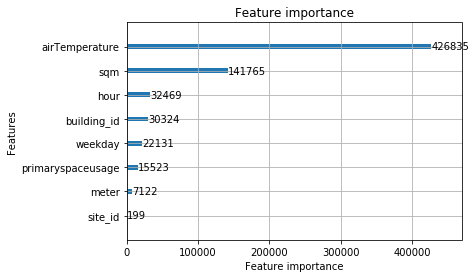

In [29]:
lgb.plot_importance(gbm)

In [30]:
# predict
print('Starting predicting...')
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
print('Finish.')

Starting predicting...
Finish.


In [31]:
values, counts = np.unique(y_pred, return_counts=True)

In [32]:
print(values)
print(counts)

[ -29293.54747989  -25588.66143363  -18595.23392189 ... 1604770.26321889
 1613952.32240056 1624990.92041385]
[1 1 1 ... 1 1 1]


In [33]:
print("Unique values: " + str(len(values)))
print("Min value: " + str(min(values)))
print("Max value: " + str(max(values)))

Unique values: 35616
Min value: -29293.54747989481
Max value: 1624990.9204138473


In [34]:
# Save LightGBM prediction
pd.DataFrame(y_pred).to_csv("..\\data\\predictions\\shortterm-winter_LGBM.csv", index=False, header="LGBM")

### Predictions dataset

To export a single dataset with all the predictions.

In [35]:
del(X_train, X_val, y_train, y_val)
gc.collect()

256

In [36]:
# Filepath
files = glob("..\\data\\predictions\\shortterm-winter*")

In [37]:
files

['..\\data\\predictions\\shortterm-winter_LGBM.csv',
 '..\\data\\predictions\\shortterm-winter_real.csv']

In [38]:
df_pred = ConcatAllModels(files)

In [39]:
df_pred = df_pred[["timestamp","building_id","meter","meter_reading","LGBM"]]

In [40]:
df_pred.head()

,timestamp,building_id,meter,meter_reading,LGBM
0,2017-02-01 00:00:00,Panther_lodging_Cora,chilledwater,136.0769,1464.273186
1,2017-02-01 01:00:00,Panther_lodging_Cora,chilledwater,123.7063,1458.233921
2,2017-02-01 02:00:00,Panther_lodging_Cora,chilledwater,111.3357,1045.975740
3,2017-02-01 03:00:00,Panther_lodging_Cora,chilledwater,86.5944,1045.975740
4,2017-02-01 04:00:00,Panther_lodging_Cora,chilledwater,86.5944,1045.975740


In [41]:
# Saves files
df_pred.to_csv("..\\data\\predictions\\shortterm-winter_pred.csv", index=False)

### Summer

In [5]:
# Load dataset
data = pd.read_csv(path_meter_proc + "dev_merged.csv")
# Reduce memory
data = reduce_mem_usage(data)

Mem. usage decreased to 2282.59 Mb (39.8% reduction)


In [6]:
# Rounds to 4 decimals
data["meter_reading"] = data['meter_reading'].astype(float).round(4)
data["airTemperature"] = data['airTemperature'].astype(float).round(2)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45159855 entries, 0 to 45159854
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   timestamp          object 
 1   building_id        object 
 2   meter_reading      float64
 3   meter              object 
 4   month              int8   
 5   weekday            int8   
 6   hour               int8   
 7   site_id            object 
 8   primaryspaceusage  object 
 9   sqm                float32
 10  airTemperature     float64
dtypes: float32(1), float64(2), int8(3), object(5)
memory usage: 2.6+ GB


In [8]:
data.head()

,timestamp,building_id,meter_reading,meter,month,weekday,hour,site_id,primaryspaceusage,sqm,airTemperature
0,2016-02-29 09:00:00,Panther_office_Clementine,136.0769,chilledwater,2,0,9,Panther,other,3100.199951,16.70
1,2016-02-29 10:00:00,Panther_office_Clementine,222.6714,chilledwater,2,0,10,Panther,other,3100.199951,21.09
2,2016-02-29 11:00:00,Panther_office_Clementine,235.0420,chilledwater,2,0,11,Panther,other,3100.199951,21.70
3,2016-02-29 12:00:00,Panther_office_Clementine,247.4126,chilledwater,2,0,12,Panther,other,3100.199951,22.20
4,2016-02-29 13:00:00,Panther_office_Clementine,272.1539,chilledwater,2,0,13,Panther,other,3100.199951,23.91


In [9]:
# Converts to timestamp
data["timestamp"] = pd.to_datetime(data["timestamp"], format='%Y-%m-%d %H:%M:%S')

In [10]:
# Strategy split
train = data[(data["timestamp"] >= "2017-07-01 00:00:00") & (data["timestamp"] < "2017-08-01 00:00:00")]
val = data[(data["timestamp"] >= "2017-08-01 00:00:00") & (data["timestamp"] < "2017-08-04 00:00:00")]
test = data[(data["timestamp"] >= "2017-08-04 00:00:00") & (data["timestamp"] < "2017-08-07 00:00:00")]
del(data)

Let's check we have the same buildings in all datasets:

In [11]:
# List of unique buildings in each dataset
train_bdg = pd.DataFrame(train.building_id.unique()).rename(columns={0:"bdg"})
val_bdg = pd.DataFrame(val.building_id.unique()).rename(columns={0:"bdg"})
test_bdg = pd.DataFrame(test.building_id.unique()).rename(columns={0:"bdg"})
# Number of unique buildings in each dataset
print("Buildings in train: " + str(len(train_bdg)))
print("Buildings in val: " + str(len(val_bdg)))
print("Buildings in test: " + str(len(test_bdg)))
# list of shared buildings in all datasets
shared_bdg = list(pd.merge(train_bdg, val_bdg, how="inner", on="bdg").merge(test_bdg, how="inner", on="bdg").bdg)
print("Buildings in val AND train AND test: " + str(len(shared_bdg)))

Buildings in train: 1557
Buildings in val: 1546
Buildings in test: 1547
Buildings in val AND train AND test: 1544


Let's select the shared buildings for the model:

In [12]:
train = train[train.building_id.isin(shared_bdg) == True]
val = val[val.building_id.isin(shared_bdg) == True]
test = test[test.building_id.isin(shared_bdg) == True]

### Real values

In [13]:
test_real = val[["timestamp","building_id","meter","meter_reading"]]
test_real.to_csv("..\\data\\predictions\\shortterm-summer_real.csv", index=False)

In [14]:
values, counts = np.unique(test_real.meter_reading, return_counts=True)

In [15]:
print(values)
print(counts)

[0.0000000e+00 1.0000000e-04 2.0000000e-04 ... 5.3184065e+06 5.4611775e+06
 5.5396525e+06]
[11350   433   505 ...     1     1     1]


In [16]:
print("Unique values: " + str(len(values)))
print("Min value: " + str(min(values)))
print("Max value: " + str(max(values)))

Unique values: 94300
Min value: 0.0
Max value: 5539652.5


In [17]:
del(test_real, values, counts)

### Encoding and Data/Target split

In [18]:
train = train.drop("timestamp",axis=1)
val = val.drop("timestamp",axis=1)
test = test.drop("timestamp",axis=1)

For LightGBM use only a label encoding (this algorith can handle categorical features by itself):

In [19]:
# Label Encoder
le_meter = LabelEncoder().fit(train.meter)
train["meter"] = le_meter.transform(train.meter)
val["meter"] = le_meter.transform(val.meter)
test["meter"] = le_meter.transform(test.meter)

In [20]:
# Label Encoder
le_usage = LabelEncoder().fit(train.primaryspaceusage)
train["primaryspaceusage"] = le_usage.transform(train.primaryspaceusage)
val["primaryspaceusage"] = le_usage.transform(val.primaryspaceusage)
test["primaryspaceusage"] = le_usage.transform(test.primaryspaceusage)

In [21]:
# Label Encoder
le_usage = LabelEncoder().fit(train.building_id)
train["building_id"] = le_usage.transform(train.building_id)
val["building_id"] = le_usage.transform(val.building_id)
test["building_id"] = le_usage.transform(test.building_id)

In [22]:
# Label Encoder
le_usage = LabelEncoder().fit(train.site_id)
train["site_id"] = le_usage.transform(train.site_id)
val["site_id"] = le_usage.transform(val.site_id)
test["site_id"] = le_usage.transform(test.site_id)

In [23]:
# Split datasets
X_train = train.drop("meter_reading", axis=1)
y_train = train["meter_reading"]

X_val = val.drop("meter_reading", axis=1)
y_val = val["meter_reading"]

X_test = test.drop("meter_reading", axis=1)
y_test = test["meter_reading"]

del(train, val, test)

### LightGBM prediction

Default parameters: https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [24]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(
    X_train,
    y_train,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    free_raw_data=False,
)
lgb_eval = lgb.Dataset(
    X_val,
    y_val,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    reference=lgb_train,
    free_raw_data=False,
)

lgb_test = lgb.Dataset(
    X_test,
    y_test,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    reference=lgb_train,
    free_raw_data=False,
)

In [25]:
# Parameters
params = {
    "objective": "regression",
    "metric": "rmse",
    "random_state": 55,
    "learning_rate":0.01, # default 0.1
    "max_bin":761, # Bin temperature by 0.1 ºC. default 255
    "num_leaves": 2197 # Around 0.01% of training data. default 31
}

In [26]:
# train
print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                valid_sets = lgb_eval,
                num_boost_round=100000,
                early_stopping_rounds=10000,
                verbose_eval=1000)

Starting training...


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10000 rounds
[1000]	valid_0's rmse: 57414.2
[2000]	valid_0's rmse: 58465.9
[3000]	valid_0's rmse: 58910.5
[4000]	valid_0's rmse: 59151.6
[5000]	valid_0's rmse: 59255.7
[6000]	valid_0's rmse: 59349.2
[7000]	valid_0's rmse: 59446.6
[8000]	valid_0's rmse: 59475.2
[9000]	valid_0's rmse: 59493
[10000]	valid_0's rmse: 59515.2
Early stopping, best iteration is:
[150]	valid_0's rmse: 34437.2


In [27]:
gbm.feature_importance()

array([ 12404,   2613,      0,   5977,  12237,     11,   7077,  71312,
       217769])

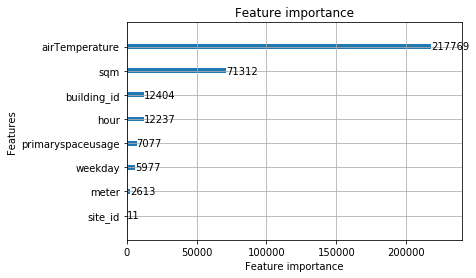

In [28]:
lgb.plot_importance(gbm)

In [29]:
# predict
print('Starting predicting...')
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
print('Finish.')

Starting predicting...
Finish.


In [30]:
values, counts = np.unique(y_pred, return_counts=True)

In [31]:
print(values)
print(counts)

[-2.17231036e+03 -1.31829932e+03  5.79819172e+02 ...  4.92492597e+06
  5.04931069e+06  5.06610919e+06]
[1 1 1 ... 1 1 1]


In [32]:
print("Unique values: " + str(len(values)))
print("Min value: " + str(min(values)))
print("Max value: " + str(max(values)))

Unique values: 15653
Min value: -2172.3103639306432
Max value: 5066109.193391525


In [33]:
# Save LightGBM prediction
pd.DataFrame(y_pred).to_csv("..\\data\\predictions\\shortterm-summer_LGBM.csv", index=False, header="LGBM")

### Predictions dataset

To export a single dataset with all the predictions.

In [34]:
del(X_train, X_val, y_train, y_val)
gc.collect()

286

In [35]:
# Filepath
files = glob("..\\data\\predictions\\shortterm-summer*")

In [36]:
files

['..\\data\\predictions\\shortterm-summer_LGBM.csv',
 '..\\data\\predictions\\shortterm-summer_real.csv']

In [37]:
df_pred = ConcatAllModels(files)

In [38]:
df_pred = df_pred[["timestamp","building_id","meter","meter_reading","LGBM"]]

In [39]:
df_pred.head()

,timestamp,building_id,meter,meter_reading,LGBM
0,2017-08-01 00:00:00,Panther_office_Clementine,chilledwater,247.4126,4405.712230
1,2017-08-01 01:00:00,Panther_office_Clementine,chilledwater,247.4126,4405.712230
2,2017-08-01 02:00:00,Panther_office_Clementine,chilledwater,235.0420,4394.333787
3,2017-08-01 03:00:00,Panther_office_Clementine,chilledwater,247.4126,4394.333787
4,2017-08-01 04:00:00,Panther_office_Clementine,chilledwater,247.4126,4373.447535


In [40]:
# Saves files
df_pred.to_csv("..\\data\\predictions\\shortterm-summer_pred.csv", index=False)